## What does this notebook do?
This notebook accesses data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_space_debris_producing_events) to plot the top debris-producing events to give us a rough estimate of what we should look into for better space safety and sustainability.

## Requirements:
To use this notebook, uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install beautifulsoup4 matplotlib pandas requests

In [2]:
from bs4 import BeautifulSoup
import io
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [3]:
# Error class to handle errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

In [4]:
uriBase = "https://en.wikipedia.org/wiki"

# List of debris producing events
dataType = "/List_of_space_debris_producing_events"

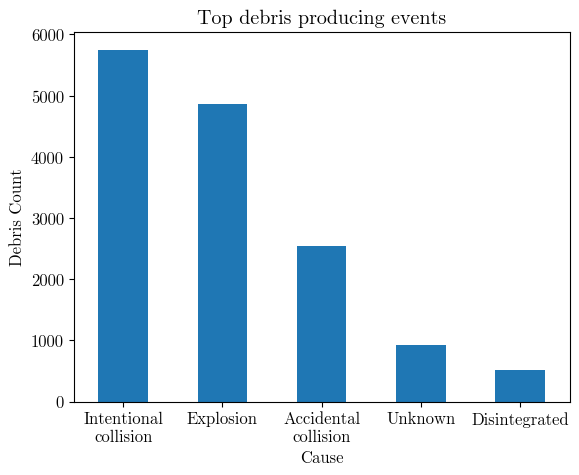

In [5]:
with requests.Session() as session:
    response1 = session.get(uriBase + dataType)
    if response1.status_code != 200:
        raise HandleError('GET')

    data1 = response1.text

    table = BeautifulSoup(data1, "html.parser").find_all('table')

    dataFrame1 = pd.read_html(io.StringIO(str(table)))[0]
    dataFrame2 = pd.read_html(io.StringIO(str(table)))[1]

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12

    dataFrame1 = dataFrame1[dataFrame1['Object'] != 'Kosmos 1408']

    dataFrame2 = dataFrame2.drop(columns = ["Pieces in Orbit", 
                                            "Reentered Pieces as of Dec 2022[a]",
                                            "International Designation"])

    dataFrame2 = dataFrame2[['Object', 
                             'Date', 
                             'Cause', 
                             "Total Pieces"]]

    dataFrame2 = dataFrame2.rename(columns = {'Date': 'Year'})
    dataFrame2 = dataFrame2.rename(columns = {'Cause': 'Notes'})
    dataFrame2 = dataFrame2.rename(columns = {"Total Pieces": 'Pieces'})
    dataFrame2 = dataFrame2.rename(columns = {'Date': 'Year'})

    dataFrame2 = dataFrame2[['Object', 'Year', 'Pieces', 'Notes']]
    dataFrame2['Year'] = dataFrame2['Year'].str.split(',').str[1]

    dataFrame2['Pieces'] = pd.to_numeric(dataFrame2['Pieces'], errors = 'coerce')
    dataFrame2 = dataFrame2.dropna(axis = 0)
    dataFrame2 = dataFrame2.reset_index(drop = True)
    dataFrame2['Pieces'] = dataFrame2['Pieces'].astype(int)

    dataFrame3 = pd.concat([dataFrame1, dataFrame2], ignore_index = True)

    dataFrame3['Year'] = dataFrame3['Year'].astype(int)

    dataFrame3['Object'] = dataFrame3['Object'].str.replace(r'\s*\[.*\]', '', regex = True)
    dataFrame3['Notes'] = dataFrame3['Notes'].str.replace(r'\s*\[.*\]', '', regex = True)

    replaceDict1 = {
        "Intentional collision (ASAT)": 'Intentional\ncollision',
        "Accidental collision with Iridium 33": 'Accidental\ncollision',
        "Residual propellant explosion": 'Explosion',
        "Accidental collision with Kosmos 2251": 'Accidental\ncollision',
        "Battery explosion": 'Explosion',
        "Engine explosion": 'Explosion',
        "ASAT (Anti-Satellite) weapon system test": 'Intentional\ncollision',
        "Unknown; Third known breakup of an H-2A Rocket Body": 'Unknown',
    }

    dataFrame3['Notes'] = dataFrame3['Notes'].replace(replaceDict1)

    dataFrame3['Notes'] = dataFrame3['Notes'].str.split().str[0]

    replaceDict2 = {
        'Intentional': "Intentional\ncollision",
        'Accidental': "Accidental\ncollision",
        'Energetic': 'Explosion',
        'Unknown,': 'Unknown',
        'Collision': 'Accidental\ncollision',
        'Unknown;': 'Unknown'
    }

    dataFrame3['Notes'] = dataFrame3['Notes'].replace(replaceDict2)

    sortedData = dataFrame3.groupby('Notes')['Pieces'].sum().sort_values(ascending = False)

    sortedData.plot.bar(rot = 0)

    plt.xlabel("Cause")
    plt.ylabel("Debris Count")

    plt.title("Top debris producing events")

    plt.show()
session.close()